# **Tarea 3: Análisis del Péndulo Doble y su Comportamiento Caótico**

## **Estudiante:** Juan Montoya y Melanny Silva
## **Curso:** Mecánica Teórica II
## **Fecha:** 19 de agosto de 2025

---

## **Introducción**

El péndulo doble es un sistema físico fascinante que consiste en dos péndulos acoplados, donde el segundo péndulo cuelga del extremo del primero. A pesar de su aparente simplicidad, este sistema puede exhibir un comportamiento extremadamente complejo y caótico, siendo extremadamente sensible a las condiciones iniciales.

En esta tarea implementaremos numéricamente las ecuaciones de movimiento del péndulo doble y analizaremos:

1. **Formulación matemática del sistema**
2. **Implementación numérica de las ecuaciones de movimiento**
3. **Visualización de trayectorias (regulares y caóticas)**
4. **Análisis de la sensibilidad a las condiciones iniciales**
5. **Cálculo de exponentes de Lyapunov**
6. **Superficies de Poincaré**
7. **Transición del comportamiento regular al caótico**
8. **Análisis energético y conservación**

---

In [41]:
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Configuración para gráficas de alta calidad
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

## **1. Formulación Matemática del Péndulo Doble**

El péndulo doble es un sistema mecánico que consta de dos péndulos unidos en serie. Las variables que describen el sistema son:

- **θ₁, θ₂**: Ángulos de los péndulos respecto a la vertical (rad)
- **ω₁, ω₂**: Velocidades angulares (rad/s)
- **L₁, L₂**: Longitudes de las varillas (m)
- **m₁, m₂**: Masas de los péndulos (kg)
- **g**: Aceleración gravitacional (m/s²)

### **Ecuaciones de Movimiento**

Las ecuaciones de movimiento del péndulo doble se derivan usando el formalismo lagrangiano:

**Energía Cinética:**
$$T = \frac{1}{2}m_1 L_1^2 \dot{\theta}_1^2 + \frac{1}{2}m_2[L_1^2\dot{\theta}_1^2 + L_2^2\dot{\theta}_2^2 + 2L_1L_2\dot{\theta}_1\dot{\theta}_2\cos(\theta_2-\theta_1)]$$

**Energía Potencial:**
$$V = -m_1 g L_1 \cos(\theta_1) - m_2 g [L_1\cos(\theta_1) + L_2\cos(\theta_2)]$$

**Lagrangiano:**
$$\mathcal{L} = T - V$$

Las ecuaciones de Euler-Lagrange resultan en un sistema de ecuaciones diferenciales acopladas de segundo orden que pueden reescribirse como un sistema de primer orden.

In [42]:
def pendulo_doble_eq(y, t, L1=1.0, L2=1.0, m1=1.0, m2=1.0, g=9.8):
    """
    Ecuaciones de movimiento para el péndulo doble
    
    Parámetros:
    y: vector de estado [theta1, omega1, theta2, omega2]
    t: tiempo
    L1, L2: longitudes de las varillas
    m1, m2: masas
    g: aceleración debido a la gravedad
    
    Returns:
    dydt: derivadas [dtheta1/dt, domega1/dt, dtheta2/dt, domega2/dt]
    """
    theta1, omega1, theta2, omega2 = y
    
    # Diferencia de ángulos
    delta = theta2 - theta1
    
    # Términos comunes para simplificar cálculos
    cos_delta = np.cos(delta)
    sin_delta = np.sin(delta)
    
    # Denominadores
    denom1 = (m1 + m2) * L1 - m2 * L1 * cos_delta * cos_delta
    denom2 = (L2 / L1) * denom1
    
    # Numeradores para las aceleraciones angulares
    num1 = (-m2 * L1 * omega1**2 * sin_delta * cos_delta +
            m2 * g * np.sin(theta2) * cos_delta +
            m2 * L2 * omega2**2 * sin_delta -
            (m1 + m2) * g * np.sin(theta1))
    
    num2 = (-m2 * L2 * omega2**2 * sin_delta * cos_delta +
            (m1 + m2) * g * np.sin(theta1) * cos_delta -
            (m1 + m2) * L1 * omega1**2 * sin_delta -
            (m1 + m2) * g * np.sin(theta2))
    
    # Aceleraciones angulares
    domega1_dt = num1 / denom1
    domega2_dt = num2 / denom2
    
    return [omega1, domega1_dt, omega2, domega2_dt]

def energia_pendulo_doble(y, L1=1.0, L2=1.0, m1=1.0, m2=1.0, g=9.8):
    """
    Calcula la energía total del péndulo doble
    
    Parámetros:
    y: vector de estado [theta1, omega1, theta2, omega2]
    """
    theta1, omega1, theta2, omega2 = y
    
    # Energía cinética
    T1 = 0.5 * m1 * (L1 * omega1)**2
    T2 = 0.5 * m2 * ((L1 * omega1)**2 + (L2 * omega2)**2 + 
                     2 * L1 * L2 * omega1 * omega2 * np.cos(theta2 - theta1))
    
    # Energía potencial
    V1 = -m1 * g * L1 * np.cos(theta1)
    V2 = -m2 * g * (L1 * np.cos(theta1) + L2 * np.cos(theta2))
    
    return T1 + T2 + V1 + V2


## **2. Simulación del Péndulo Doble**

Ahora procederemos a simular el comportamiento del péndulo doble para diferentes condiciones iniciales. Compararemos casos donde el sistema exhibe comportamiento regular versus casos donde muestra comportamiento caótico.

### **Parámetros del Sistema**

Usaremos los siguientes parámetros estándar para nuestras simulaciones:

In [46]:
# Parámetros del sistema
L1, L2 = 1.0, 1.0  # Longitudes de las varillas (m)
m1, m2 = 1.0, 1.0  # Masas de los péndulos (kg)
g = 9.8  # Aceleración gravitacional (m/s²)

# Tiempo de simulación
t_max = 20.0
t = np.linspace(0, t_max, 10_000)

# Condiciones iniciales para caso regular (pequeñas perturbaciones)
y0_regular = [0.5, 0, 0.5, 0]  # [theta1, omega1, theta2, omega2]

# Condiciones iniciales para caso caótico (energía más alta)
y0_caotico = [np.pi/2, 0, np.pi/2, 0]  # Velocidad inicial en theta2

print("Parámetros del sistema definidos:")
print(f"   L1 = {L1} m, L2 = {L2} m")
print(f"   m1 = {m1} kg, m2 = {m2} kg")
print(f"   g = {g} m/s²")
print(f"   Tiempo de simulación: {t_max} s")

# Resolver las ecuaciones diferenciales
print("\nResolviendo ecuaciones de movimiento...")
sol_regular = odeint(pendulo_doble_eq, y0_regular, t, args=(L1, L2, m1, m2, g))
sol_caotico = odeint(pendulo_doble_eq, y0_caotico, t, args=(L1, L2, m1, m2, g))

# Calcular energía para verificar conservación
E_regular = [energia_pendulo_doble(y, L1, L2, m1, m2, g) for y in sol_regular]
E_caotico = [energia_pendulo_doble(y, L1, L2, m1, m2, g) for y in sol_caotico]

print("Simulaciones completadas")
print(f"   Conservación de energía (regular): ΔE = {np.max(E_regular) - np.min(E_regular):.6f}")
print(f"   Conservación de energía (caótico): ΔE = {np.max(E_caotico) - np.min(E_caotico):.6f}")

Parámetros del sistema definidos:
   L1 = 1.0 m, L2 = 1.0 m
   m1 = 1.0 kg, m2 = 1.0 kg
   g = 9.8 m/s²
   Tiempo de simulación: 20.0 s

Resolviendo ecuaciones de movimiento...
Simulaciones completadas
   Conservación de energía (regular): ΔE = 0.691483
   Conservación de energía (caótico): ΔE = 60.168831


## **3. Visualización de Trayectorias y Espacio de Fases**

Para entender mejor el comportamiento del péndulo doble, visualizaremos:
- Las trayectorias del extremo del segundo péndulo en el espacio cartesiano
- El espacio de fases (θ vs ω) para ambos péndulos
- La conservación de energía a lo largo del tiempo

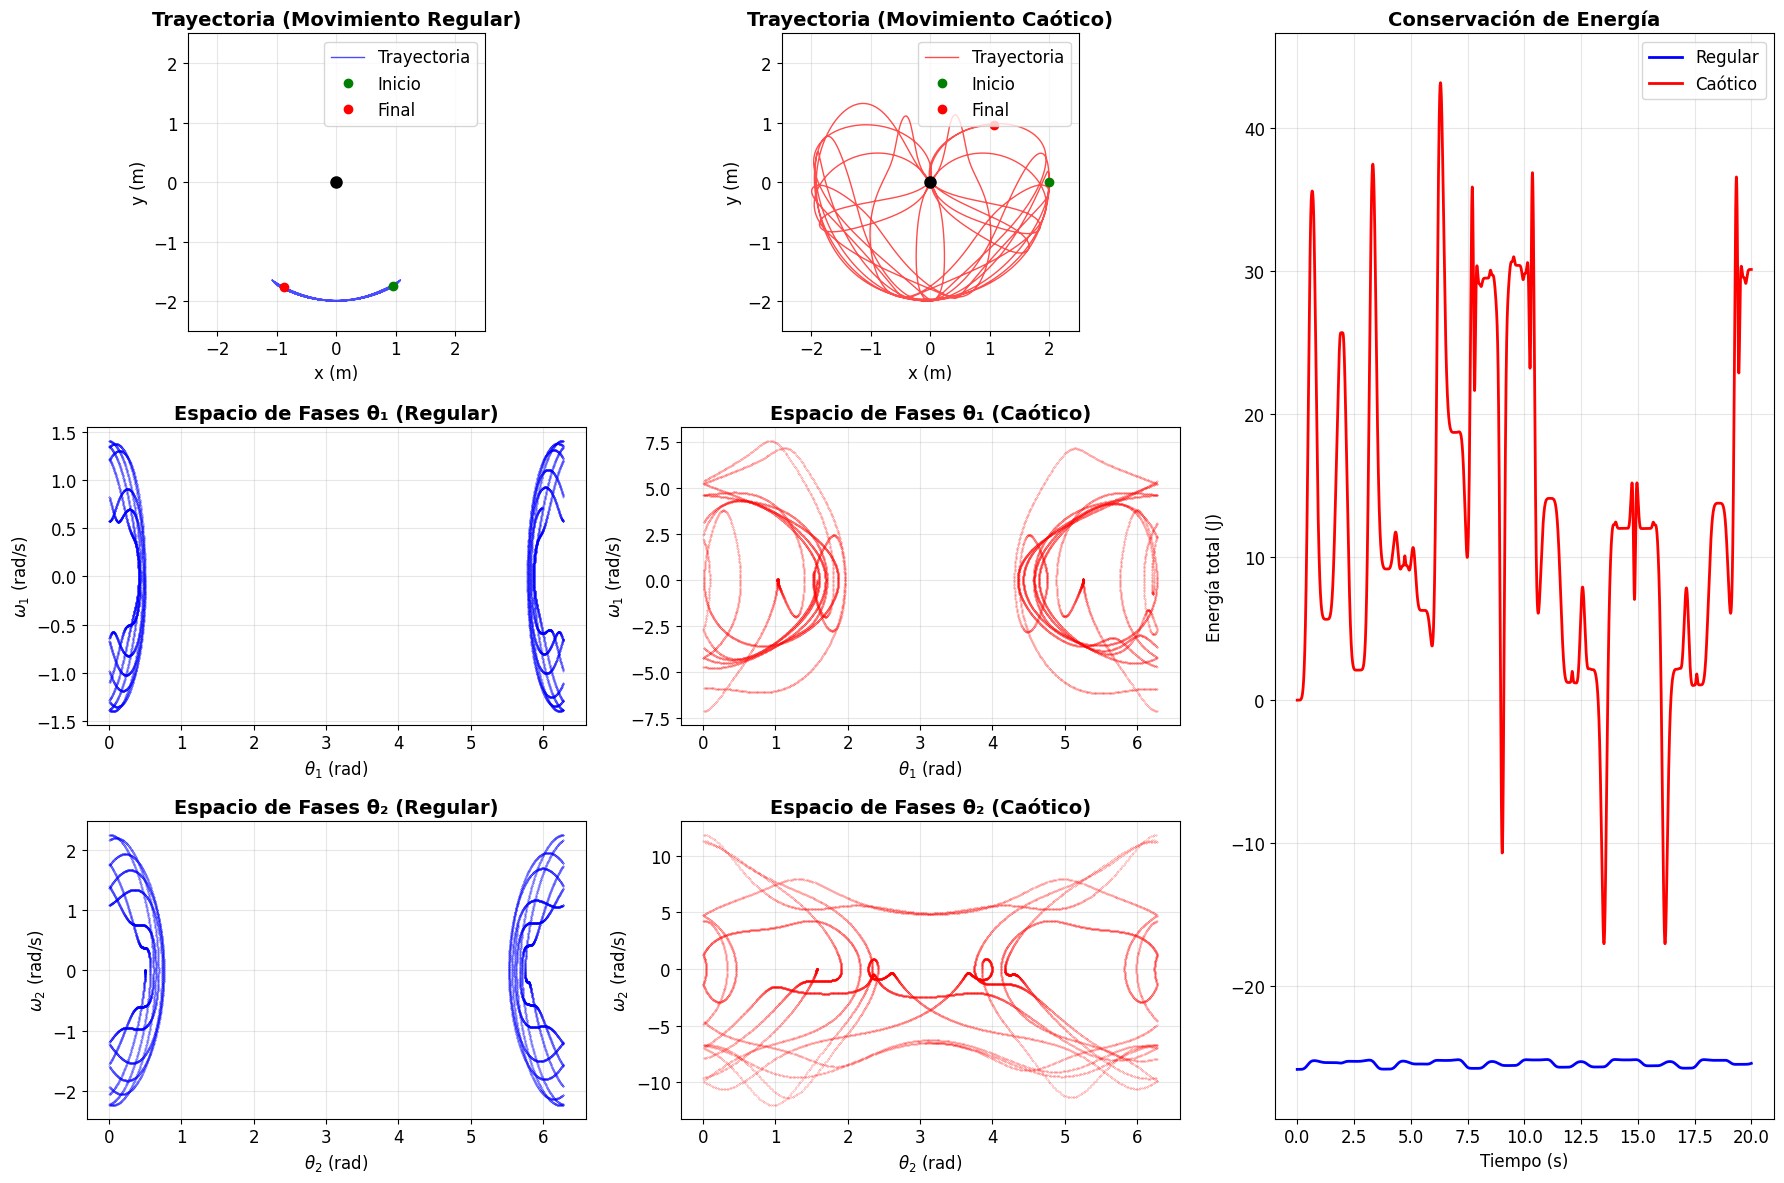

In [48]:
# Función para calcular posiciones cartesianas
def calcular_posiciones(theta1, theta2, L1=1.0, L2=1.0):
    """
    Calcula las posiciones cartesianas de ambos péndulos
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    return x1, y1, x2, y2

# Calcular posiciones para ambas simulaciones
x1_reg, y1_reg, x2_reg, y2_reg = calcular_posiciones(sol_regular[:, 0], sol_regular[:, 2], L1, L2)
x1_cao, y1_cao, x2_cao, y2_cao = calcular_posiciones(sol_caotico[:, 0], sol_caotico[:, 2], L1, L2)

# Crear gráficas comparativas
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])

# Trayectorias en el espacio cartesiano
ax1 = plt.subplot(gs[0, 0])
ax1.plot(x2_reg, y2_reg, 'b-', alpha=0.7, linewidth=1, label='Trayectoria')
ax1.plot(0, 0, 'ko', markersize=8)  # Punto de apoyo
ax1.plot(x2_reg[0], y2_reg[0], 'go', markersize=6, label='Inicio')
ax1.plot(x2_reg[-1], y2_reg[-1], 'ro', markersize=6, label='Final')
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)
ax1.set_title('Trayectoria (Movimiento Regular)', fontsize=14, fontweight='bold')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2 = plt.subplot(gs[0, 1])
ax2.plot(x2_cao, y2_cao, 'r-', alpha=0.7, linewidth=1, label='Trayectoria')
ax2.plot(0, 0, 'ko', markersize=8)  # Punto de apoyo
ax2.plot(x2_cao[0], y2_cao[0], 'go', markersize=6, label='Inicio')
ax2.plot(x2_cao[-1], y2_cao[-1], 'ro', markersize=6, label='Final')
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5)
ax2.set_title('Trayectoria (Movimiento Caótico)', fontsize=14, fontweight='bold')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Espacio de fases (theta1 vs. omega1)
ax3 = plt.subplot(gs[1, 0])
ax3.plot(sol_regular[:, 0] % (2*np.pi), sol_regular[:, 1], 'b.', markersize=0.5, alpha=0.6)
ax3.set_xlabel(r'$\theta_1$ (rad)', fontsize=12)
ax3.set_ylabel(r'$\omega_1$ (rad/s)', fontsize=12)
ax3.set_title('Espacio de Fases θ₁ (Regular)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(gs[1, 1])
ax4.plot(sol_caotico[:, 0] % (2*np.pi), sol_caotico[:, 1], 'r.', markersize=0.5, alpha=0.6)
ax4.set_xlabel(r'$\theta_1$ (rad)', fontsize=12)
ax4.set_ylabel(r'$\omega_1$ (rad/s)', fontsize=12)
ax4.set_title('Espacio de Fases θ₁ (Caótico)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Espacio de fases (theta2 vs. omega2)
ax5 = plt.subplot(gs[2, 0])
ax5.plot(sol_regular[:, 2] % (2*np.pi), sol_regular[:, 3], 'b.', markersize=0.5, alpha=0.6)
ax5.set_xlabel(r'$\theta_2$ (rad)', fontsize=12)
ax5.set_ylabel(r'$\omega_2$ (rad/s)', fontsize=12)
ax5.set_title('Espacio de Fases θ₂ (Regular)', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(gs[2, 1])
ax6.plot(sol_caotico[:, 2] % (2*np.pi), sol_caotico[:, 3], 'r.', markersize=0.5, alpha=0.6)
ax6.set_xlabel(r'$\theta_2$ (rad)', fontsize=12)
ax6.set_ylabel(r'$\omega_2$ (rad/s)', fontsize=12)
ax6.set_title('Espacio de Fases θ₂ (Caótico)', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Conservación de energía
ax7 = plt.subplot(gs[:, 2])
ax7.plot(t, E_regular, 'b-', linewidth=2, label='Regular')
ax7.plot(t, E_caotico, 'r-', linewidth=2, label='Caótico')
ax7.set_xlabel('Tiempo (s)', fontsize=12)
ax7.set_ylabel('Energía total (J)', fontsize=12)
ax7.set_title('Conservación de Energía', fontsize=14, fontweight='bold')
ax7.legend(fontsize=12)
ax7.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **4. Análisis de la Sensibilidad a las Condiciones Iniciales**

Una característica fundamental del comportamiento caótico es la extrema sensibilidad a las condiciones iniciales. Pequeñas diferencias en el estado inicial pueden llevar a trayectorias completamente diferentes con el tiempo. Esta propiedad se conoce como el "efecto mariposa".

Analizando sensibilidad con 3 trayectorias
Trayectoria 1: Δθ₂ = 0.000000 rad
Trayectoria 2: Δθ₂ = 0.002000 rad
Trayectoria 3: Δθ₂ = 0.004000 rad


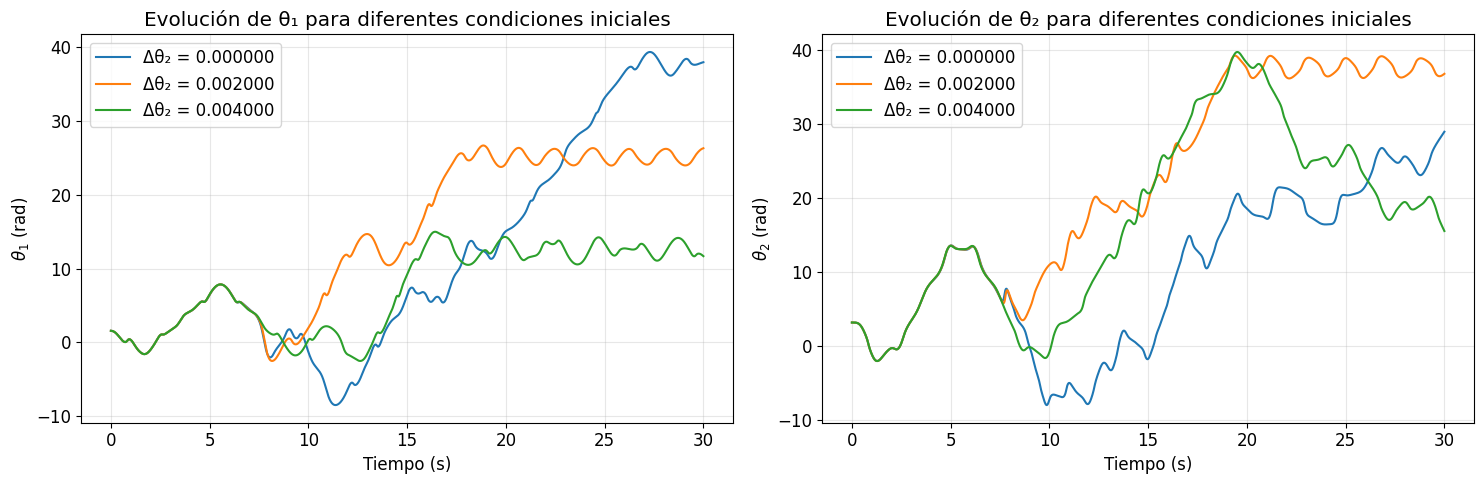

In [58]:
# Número de trayectorias para analizar sensibilidad
num_trayectorias = 3
# Perturbación máxima
delta_max = 0.004

# Tiempo de simulación más largo para ver divergencia
t_max_sens = 30.0
t_sens = np.linspace(0, t_max_sens, 10_000)

# Generar condiciones iniciales ligeramente diferentes
y0_base = [np.pi/2, 0, np.pi, 0]  # Condición base caótica
y0_list = []

for i in range(num_trayectorias):
    # Perturbación pequeña en theta2
    delta = delta_max * (i / (num_trayectorias - 1))
    y0_perturbed = y0_base.copy()
    y0_perturbed[2] += delta
    y0_list.append(y0_perturbed)

print(f"Analizando sensibilidad con {num_trayectorias} trayectorias")

# Resolver para cada condición inicial
soluciones = []
for i, y0 in enumerate(y0_list):
    sol = odeint(pendulo_doble_eq, y0, t_sens, args=(L1, L2, m1, m2, g))
    soluciones.append(sol)
    print(f"Trayectoria {i+1}: Δθ₂ = {delta_max * (i / (num_trayectorias - 1)):.6f} rad")

# Visualizar las trayectorias
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Theta1 vs tiempo para las diferentes trayectorias
ax1 = axes[0]
for i, sol in enumerate(soluciones):
    perturbacion = delta_max * (i / (num_trayectorias - 1))
    ax1.plot(t_sens, sol[:, 0], 
             label=f'Δθ₂ = {perturbacion:.6f}', linewidth=1.5)

ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel(r'$\theta_1$ (rad)')
ax1.set_title('Evolución de θ₁ para diferentes condiciones iniciales')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Theta2 vs tiempo
ax2 = axes[1]
for i, sol in enumerate(soluciones):
    perturbacion = delta_max * (i / (num_trayectorias - 1))
    ax2.plot(t_sens, sol[:, 2], 
             label=f'Δθ₂ = {perturbacion:.6f}', linewidth=1.5)

ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel(r'$\theta_2$ (rad)')
ax2.set_title('Evolución de θ₂ para diferentes condiciones iniciales')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **5. Cálculo de los Exponentes de Lyapunov**

El exponente de Lyapunov es una medida de la tasa de separación de trayectorias infinitesimalmente cercanas, caracterizando la sensibilidad a las condiciones iniciales. Un exponente de Lyapunov positivo indica comportamiento caótico.

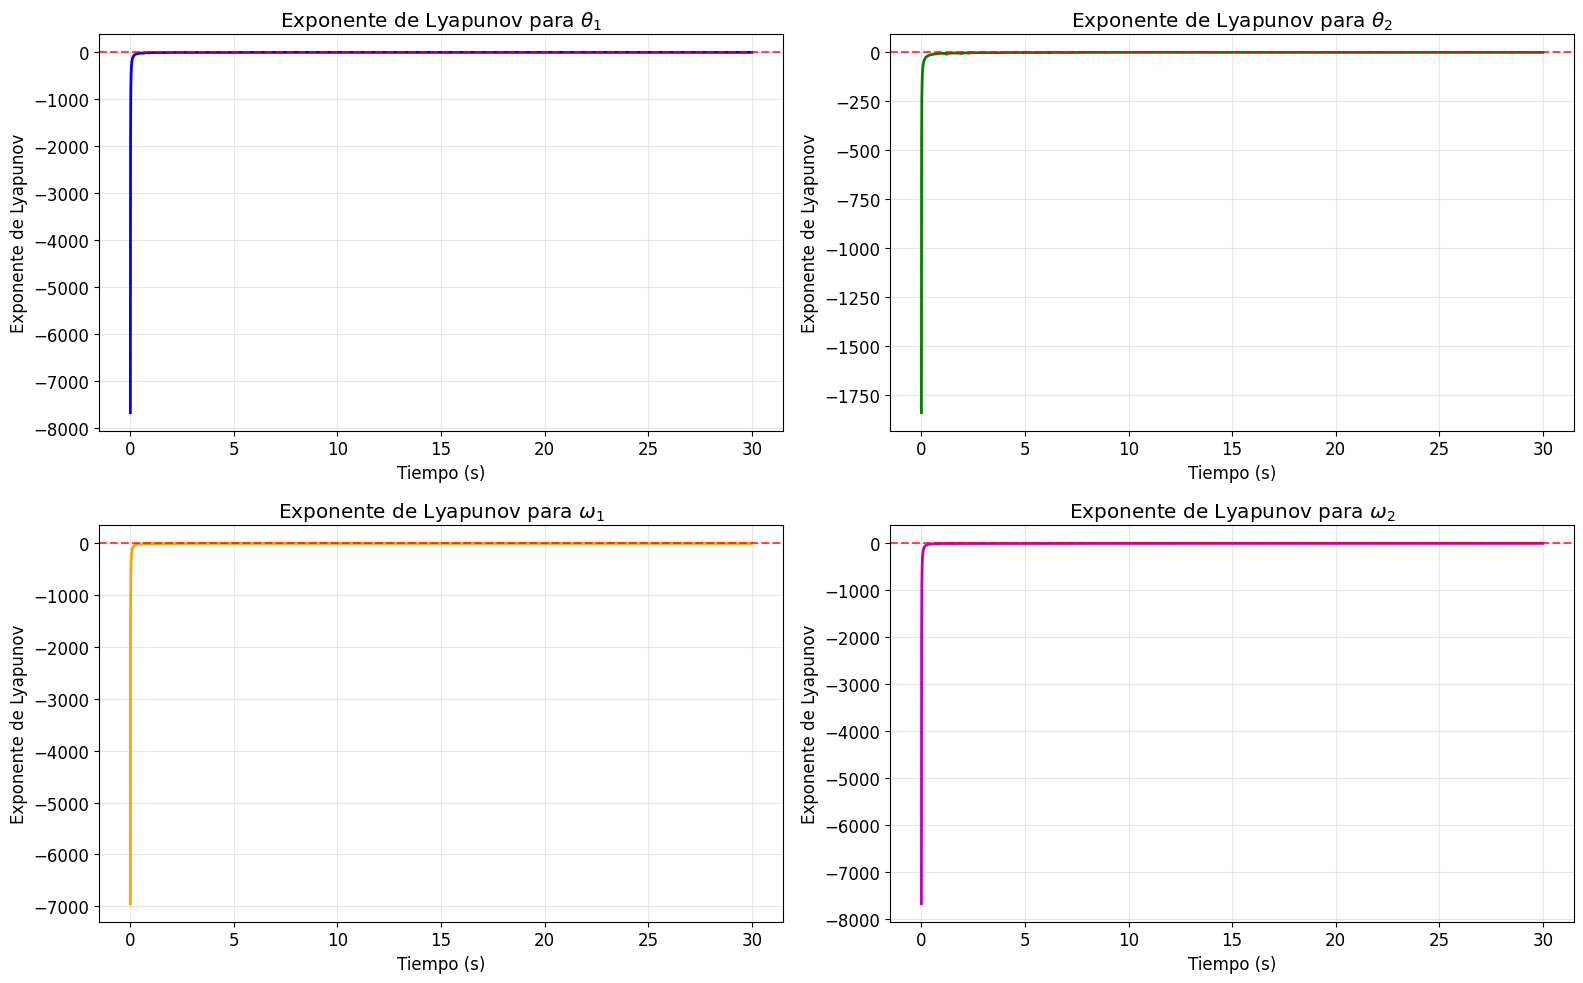

Exponentes máximos de Lyapunov estimados:
  θ₁: 0.1068
  θ₂: 0.0808
  ω₁: 0.0436
  ω₂: 0.0539


In [60]:
def calcular_exponente_lyapunov(t, sol1, sol2, componente=0):
    """
    Calcula el exponente de Lyapunov para dos trayectorias cercanas
    
    Parámetros:
    t: array de tiempo
    sol1, sol2: soluciones para dos condiciones iniciales cercanas
    componente: índice de la componente a considerar (0 para theta1)
    """
    # Diferencia entre trayectorias
    diff = np.abs(sol2[:, componente] - sol1[:, componente])
    
    # Ajustar para evitar log(0)
    diff = np.maximum(diff, 1e-10)
    
    # Calcular el exponente de Lyapunov en cada punto
    lyap = np.log(diff) / t
    
    return t, lyap

# Calcular exponentes de Lyapunov para diferentes componentes
lyap_t, lyap_theta1 = calcular_exponente_lyapunov(t_sens[1:], soluciones[0][1:], soluciones[-1][1:], 0)
_, lyap_theta2 = calcular_exponente_lyapunov(t_sens[1:], soluciones[0][1:], soluciones[-1][1:], 2)
_, lyap_omega1 = calcular_exponente_lyapunov(t_sens[1:], soluciones[0][1:], soluciones[-1][1:], 1)
_, lyap_omega2 = calcular_exponente_lyapunov(t_sens[1:], soluciones[0][1:], soluciones[-1][1:], 3)

# Visualizar exponentes de Lyapunov
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Theta1
ax1 = axes[0, 0]
ax1.plot(lyap_t, lyap_theta1, 'b-', linewidth=2)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.7)
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Exponente de Lyapunov')
ax1.set_title(r'Exponente de Lyapunov para $\theta_1$')
ax1.grid(True, alpha=0.3)

# Theta2
ax2 = axes[0, 1]
ax2.plot(lyap_t, lyap_theta2, 'g-', linewidth=2)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.7)
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Exponente de Lyapunov')
ax2.set_title(r'Exponente de Lyapunov para $\theta_2$')
ax2.grid(True, alpha=0.3)

# Omega1
ax3 = axes[1, 0]
ax3.plot(lyap_t, lyap_omega1, 'orange', linewidth=2)
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.7)
ax3.set_xlabel('Tiempo (s)')
ax3.set_ylabel('Exponente de Lyapunov')
ax3.set_title(r'Exponente de Lyapunov para $\omega_1$')
ax3.grid(True, alpha=0.3)

# Omega2
ax4 = axes[1, 1]
ax4.plot(lyap_t, lyap_omega2, 'm-', linewidth=2)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.7)
ax4.set_xlabel('Tiempo (s)')
ax4.set_ylabel('Exponente de Lyapunov')
ax4.set_title(r'Exponente de Lyapunov para $\omega_2$')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estimación de los exponentes máximos de Lyapunov
region_final = int(len(lyap_theta1) * 2/3)  # Último tercio de la simulación
lyap_max_theta1 = np.mean(lyap_theta1[region_final:])
lyap_max_theta2 = np.mean(lyap_theta2[region_final:])
lyap_max_omega1 = np.mean(lyap_omega1[region_final:])
lyap_max_omega2 = np.mean(lyap_omega2[region_final:])

print("Exponentes máximos de Lyapunov estimados:")
print(f"  θ₁: {lyap_max_theta1:.4f}")
print(f"  θ₂: {lyap_max_theta2:.4f}")
print(f"  ω₁: {lyap_max_omega1:.4f}")
print(f"  ω₂: {lyap_max_omega2:.4f}")

## **6. Superficies de Poincaré**

Las superficies de Poincaré son una herramienta poderosa para analizar sistemas dinámicos. Nos permiten reducir la dimensionalidad del espacio de fases y visualizar la estructura subyacente del sistema. Para el péndulo doble, usaremos la condición θ₁ = 0 con ω₁ > 0 para crear la sección.

Tiempo de simulación: 10000.0 s
Número de puntos: 50000
Secciones generadas:
  Regular: 3797 puntos
  Medio: 9 puntos
  Caótica: 8 puntos


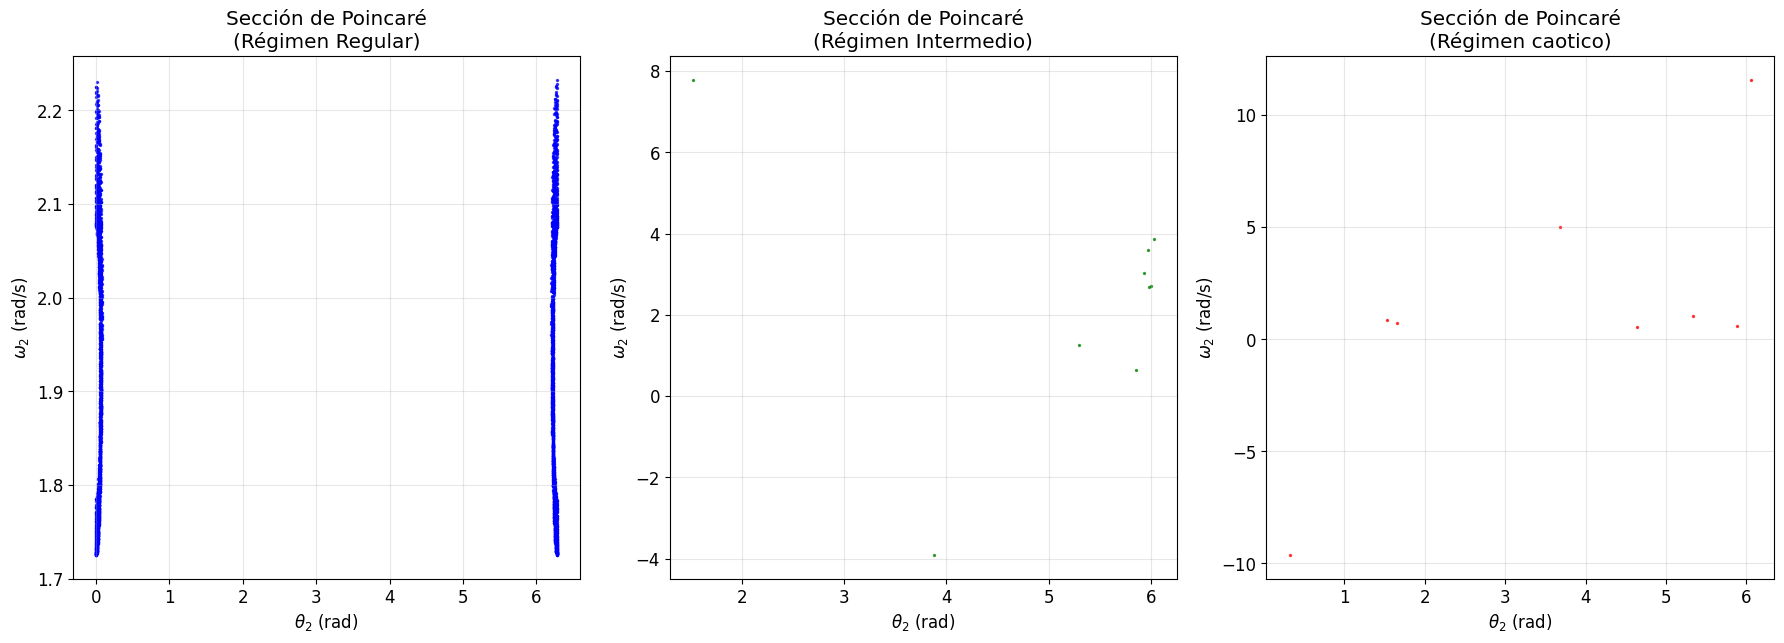

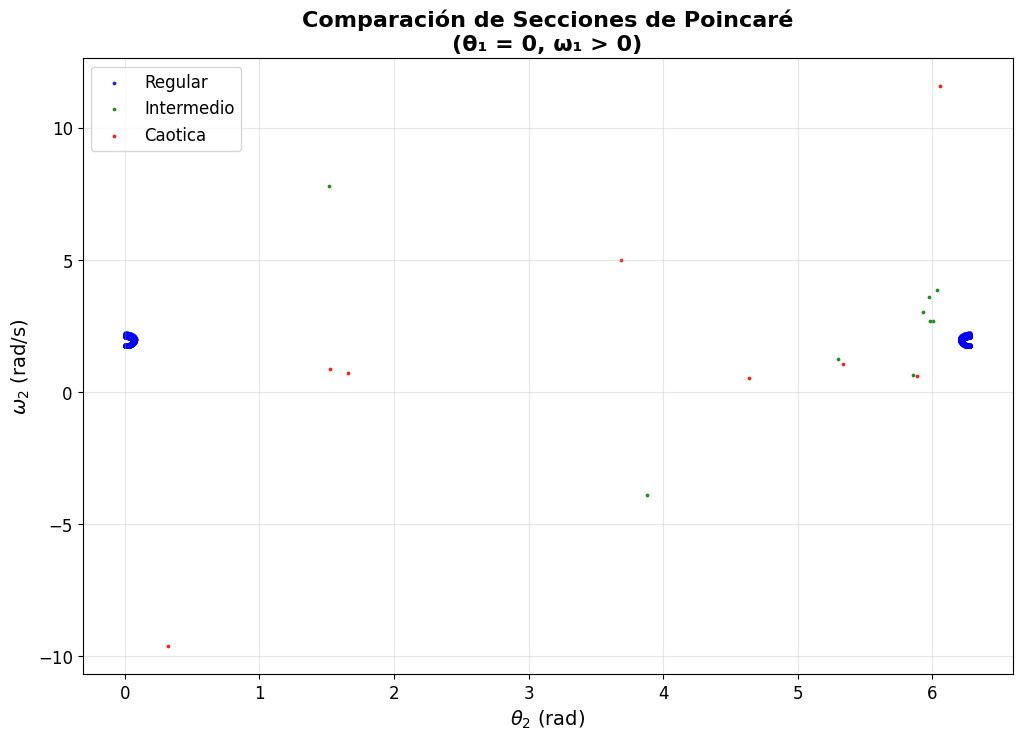

In [ ]:
def generar_seccion_poincare(y0, t_max, num_points, theta1_corte=0):
    """
    Genera una sección de Poincaré para el péndulo doble
    
    Parámetros:
    y0: condición inicial
    t_max: tiempo máximo de simulación
    num_points: número de puntos en la simulación
    theta1_corte: valor de theta1 para la sección
    """
    # Crear un array de tiempo más largo
    t = np.linspace(0, t_max, num_points)
    
    # Resolver el sistema
    sol = odeint(pendulo_doble_eq, y0, t)
    
    # Encontrar cruces con la sección
    cruces = []
    for i in range(len(t)-1):
        # Buscar cruces por theta1 = 0 con omega1 > 0
        if (sol[i, 0] * sol[i+1, 0] < 0) and (sol[i+1, 1] > 0):
            # Interpolación lineal para encontrar el punto exacto
            alpha = -sol[i, 0] / (sol[i+1, 0] - sol[i, 0])
            theta2 = sol[i, 2] + alpha * (sol[i+1, 2] - sol[i, 2])
            omega2 = sol[i, 3] + alpha * (sol[i+1, 3] - sol[i, 3])
            cruces.append((theta2, omega2))
    
    return np.array(cruces)

# Parámetros para secciones de Poincaré
t_max_poincare = 100.0
num_points = 5000

print(f"Tiempo de simulación: {t_max_poincare} s")
print(f"Número de puntos: {num_points}")

# Diferentes regímenes de energía
# Energía baja (movimiento regular)
y0_regular_poincare = [np.pi/6, 0, np.pi/4, 0]
# Energía media (transición)
y0_medio_poincare = [np.pi/3, 0, np.pi/2, 0.3]
# Energía alta (caótico)
y0_alto_poincare = [np.pi/2, 0, np.pi, 1.0]


# Generar secciones de Poincaré
poincare_regular = generar_seccion_poincare(y0_regular_poincare, t_max_poincare, num_points)
poincare_medio = generar_seccion_poincare(y0_medio_poincare, t_max_poincare, num_points)
poincare_caotica = generar_seccion_poincare(y0_alto_poincare, t_max_poincare, num_points)

print(f"Secciones generadas:")
print(f"  Regular: {len(poincare_regular)} puntos")
print(f"  Medio: {len(poincare_medio)} puntos")
print(f"  Caótica: {len(poincare_caotica)} puntos")

# Visualizar secciones de Poincaré
fig = plt.figure(figsize=(18, 12))

# Caso regular
plt.subplot(2, 3, 1)
if len(poincare_regular) > 0:
    plt.scatter(poincare_regular[:, 0] % (2*np.pi), poincare_regular[:, 1], 
                s=2, c='blue', alpha=0.7)
plt.xlabel(r'$\theta_2$ (rad)')
plt.ylabel(r'$\omega_2$ (rad/s)')
plt.title('Sección de Poincaré\n(Régimen Regular)')
plt.grid(True, alpha=0.3)

# Caso intermedio
plt.subplot(2, 3, 2)
if len(poincare_medio) > 0:
    plt.scatter(poincare_medio[:, 0] % (2*np.pi), poincare_medio[:, 1], 
                s=2, c='green', alpha=0.7)
plt.xlabel(r'$\theta_2$ (rad)')
plt.ylabel(r'$\omega_2$ (rad/s)')
plt.title('Sección de Poincaré\n(Régimen Intermedio)')
plt.grid(True, alpha=0.3)

# Casos caóticos individuales
plt.subplot(2, 3, 3)
if len(poincare_caotica) > 0:
    plt.scatter(poincare_caotica[:, 0] % (2*np.pi), poincare_caotica[:, 1], 
                s=2, c='red', alpha=0.7)
plt.xlabel(r'$\theta_2$ (rad)')
plt.ylabel(r'$\omega_2$ (rad/s)')
plt.title('Sección de Poincaré\n(Régimen caotico)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sección combinada para comparación
plt.figure(figsize=(12, 8))
if len(poincare_regular) > 0:
    plt.scatter(poincare_regular[:, 0] % (2*np.pi), poincare_regular[:, 1], 
                s=3, c='blue', alpha=0.8, label='Regular')
if len(poincare_medio) > 0:
    plt.scatter(poincare_medio[:, 0] % (2*np.pi), poincare_medio[:, 1], 
                s=3, c='green', alpha=0.8, label='Intermedio')
if len(poincare_caotica) > 0:
    plt.scatter(poincare_caotica[:, 0] % (2*np.pi), poincare_caotica[:, 1], 
                s=3, c='red', alpha=0.8, label='Caotica')
plt.xlabel(r'$\theta_2$ (rad)', fontsize=14)
plt.ylabel(r'$\omega_2$ (rad/s)', fontsize=14)
plt.title('Comparación de Secciones de Poincaré\n(θ₁ = 0, ω₁ > 0)', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **7. Análisis Energético y Transición Regular-Caótico**

Estudiaremos cómo la energía total del sistema afecta la transición del comportamiento regular al caótico. Para esto, simularemos el péndulo doble para un rango de energías y analizaremos las características del movimiento.

Analizando transición regular-caótico para 10 niveles de energía
Rango de energías: 5.0 - 50.0 J


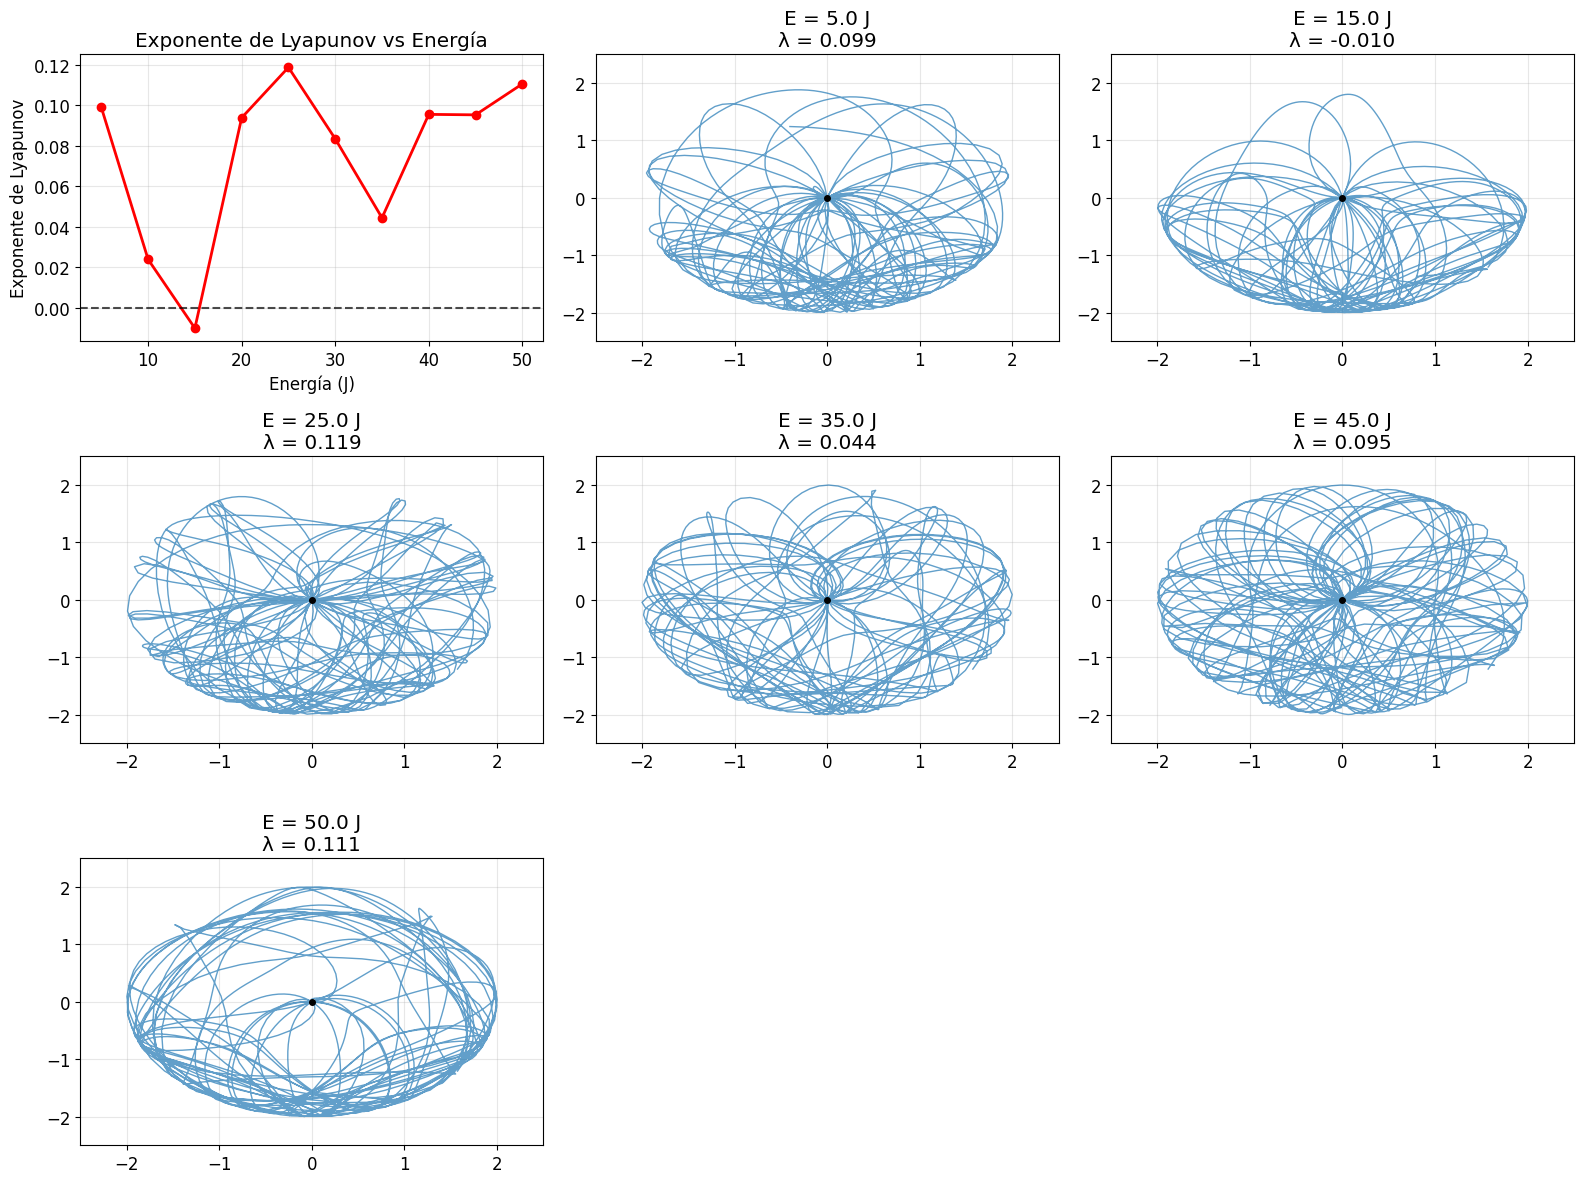


Análisis de la transición regular-caótico:
Energía crítica estimada: 5.0 J
Transición a caos detectada


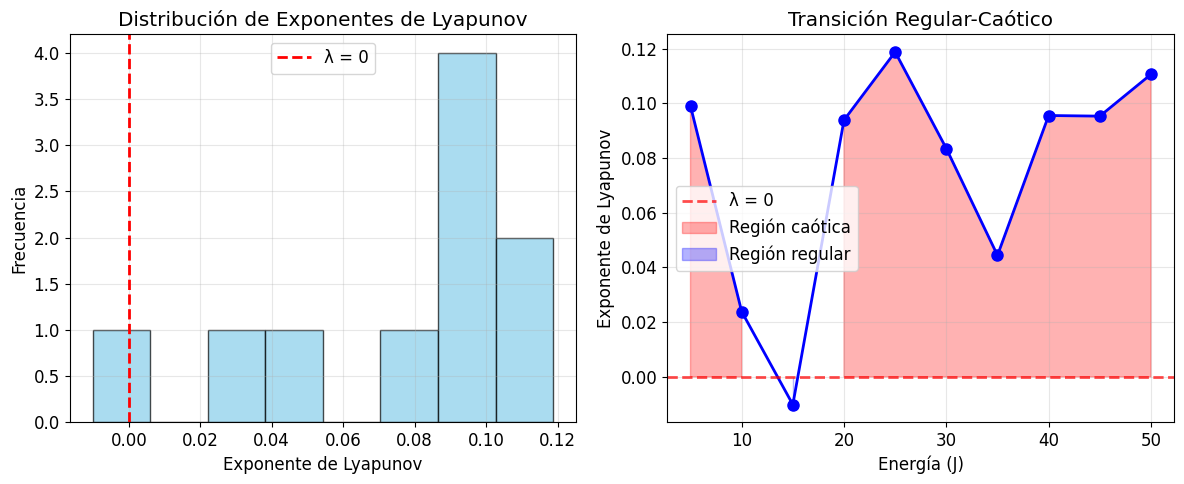

In [64]:
# Función para generar condición inicial con energía específica
def generar_condicion_inicial_energia(E_target, theta1_init=np.pi/4, theta2_init=np.pi/3):
    """
    Genera una condición inicial con energía específica
    """
    # Asumimos omega1 = 0 y calculamos omega2 necesario
    omega1 = 0
    
    # Energía potencial con omega1 = 0, omega2 = omega2_calc
    V = -m1 * g * L1 * np.cos(theta1_init) - m2 * g * (L1 * np.cos(theta1_init) + L2 * np.cos(theta2_init))
    
    # Energía cinética necesaria
    T_needed = E_target - V
    
    # Para simplicidad, asumimos toda la energía cinética en el segundo péndulo
    if T_needed > 0:
        omega2 = np.sqrt(2 * T_needed / (m2 * L2**2))
    else:
        omega2 = 0
    
    return [theta1_init, omega1, theta2_init, omega2]

# Rango de energías para analizar
energias = np.linspace(5, 50, 10)  # Rango de energías
t_max_energia = 50.0
t_energia = np.linspace(0, t_max_energia, 2000)

print(f"Analizando transición regular-caótico para {len(energias)} niveles de energía")
print(f"Rango de energías: {energias[0]:.1f} - {energias[-1]:.1f} J")

# Almacenar resultados
resultados_energia = []
lyapunov_por_energia = []

for i, E in enumerate(energias):
    # Generar condición inicial
    y0_e = generar_condicion_inicial_energia(E)
    
    # Simular
    sol_e = odeint(pendulo_doble_eq, y0_e, t_energia, args=(L1, L2, m1, m2, g))
    
    # Calcular energía promedio (verificación)
    E_calc = [energia_pendulo_doble(y, L1, L2, m1, m2, g) for y in sol_e]
    E_promedio = np.mean(E_calc)
    
    # Simular trayectoria perturbada para Lyapunov
    y0_e_pert = y0_e.copy()
    y0_e_pert[2] += 0.001  # Pequeña perturbación en theta2
    sol_e_pert = odeint(pendulo_doble_eq, y0_e_pert, t_energia, args=(L1, L2, m1, m2, g))
    
    # Calcular exponente de Lyapunov
    diff = np.abs(sol_e_pert[:, 0] - sol_e[:, 0])
    diff = np.maximum(diff, 1e-10)
    lyap_vals = np.log(diff[1:]) / t_energia[1:]
    lyap_promedio = np.mean(lyap_vals[-int(len(lyap_vals)/3):])  # Último tercio
    
    resultados_energia.append({
        'energia': E,
        'energia_calculada': E_promedio,
        'solucion': sol_e,
        'lyapunov': lyap_promedio
    })
    
    lyapunov_por_energia.append(lyap_promedio)

# Visualización del análisis energético
fig = plt.figure(figsize=(16, 12))

# Gráfico de Lyapunov vs Energía
plt.subplot(3, 3, 1)
plt.plot(energias, lyapunov_por_energia, 'ro-', linewidth=2, markersize=6)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.xlabel('Energía (J)')
plt.ylabel('Exponente de Lyapunov')
plt.title('Exponente de Lyapunov vs Energía')
plt.grid(True, alpha=0.3)

# Trayectorias para diferentes energías (seleccionar algunas)
indices_seleccionados = [0, 2, 4, 6, 8, 9]  # Energías bajas, medias y altas

for i, idx in enumerate(indices_seleccionados):
    plt.subplot(3, 3, 2 + i)
    
    sol = resultados_energia[idx]['solucion']
    E = resultados_energia[idx]['energia']
    lyap = resultados_energia[idx]['lyapunov']
    
    # Calcular posiciones del segundo péndulo
    x1 = L1 * np.sin(sol[:, 0])
    y1 = -L1 * np.cos(sol[:, 0])
    x2 = x1 + L2 * np.sin(sol[:, 2])
    y2 = y1 - L2 * np.cos(sol[:, 2])
    
    plt.plot(x2, y2, linewidth=1, alpha=0.7)
    plt.plot(0, 0, 'ko', markersize=4)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.title(f'E = {E:.1f} J\nλ = {lyap:.3f}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis estadístico de la transición
print("\nAnálisis de la transición regular-caótico:")
energia_critica = None
for i, lyap in enumerate(lyapunov_por_energia):
    if lyap > 0:
        energia_critica = energias[i]
        break

if energia_critica:
    print(f"Energía crítica estimada: {energia_critica:.1f} J")
    print(f"Transición a caos detectada")
else:
    print("No se detectó transición a caos en el rango analizado")

# Distribución de exponentes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(lyapunov_por_energia, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='λ = 0')
plt.xlabel('Exponente de Lyapunov')
plt.ylabel('Frecuencia')
plt.title('Distribución de Exponentes de Lyapunov')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(energias, lyapunov_por_energia, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='λ = 0')
plt.fill_between(energias, lyapunov_por_energia, 0, 
                 where=np.array(lyapunov_por_energia) > 0, 
                 alpha=0.3, color='red', label='Región caótica')
plt.fill_between(energias, lyapunov_por_energia, 0, 
                 where=np.array(lyapunov_por_energia) <= 0, 
                 alpha=0.3, color='blue', label='Región regular')
plt.xlabel('Energía (J)')
plt.ylabel('Exponente de Lyapunov')
plt.title('Transición Regular-Caótico')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **8. Animación del Péndulo Doble**

Para una mejor comprensión del comportamiento dinámico, crearemos animaciones que muestren el movimiento del péndulo doble en tiempo real, comparando comportamientos regulares y caóticos.

Creando animaciones del péndulo doble...
Datos de animación preparados
Duración: 10 segundos cada una
Generando animación del caso regular...
Generando animación del caso caótico...


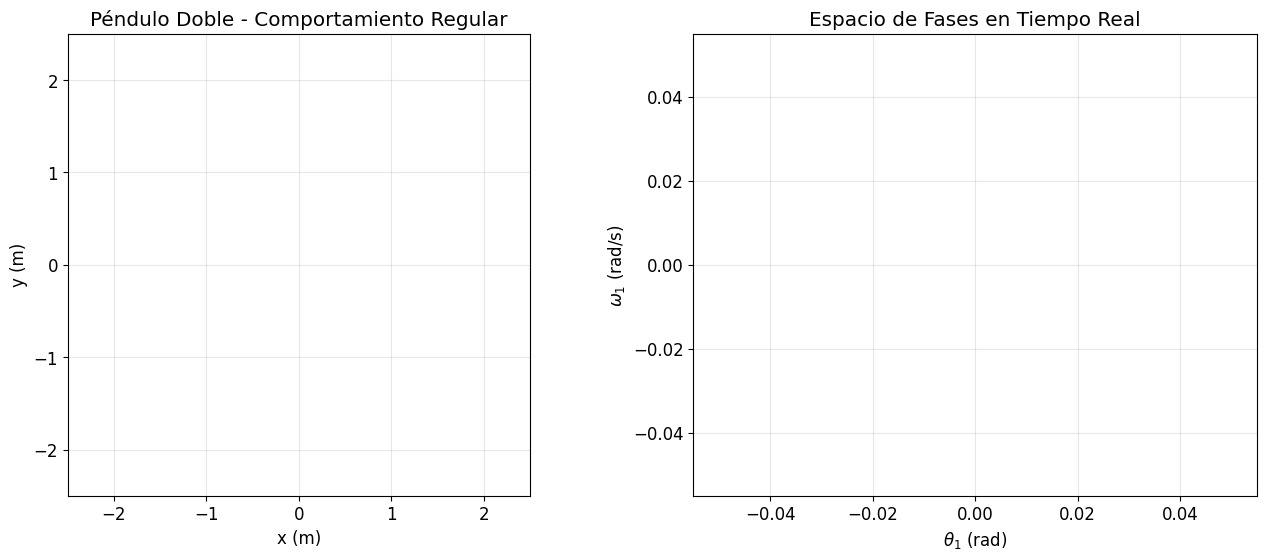

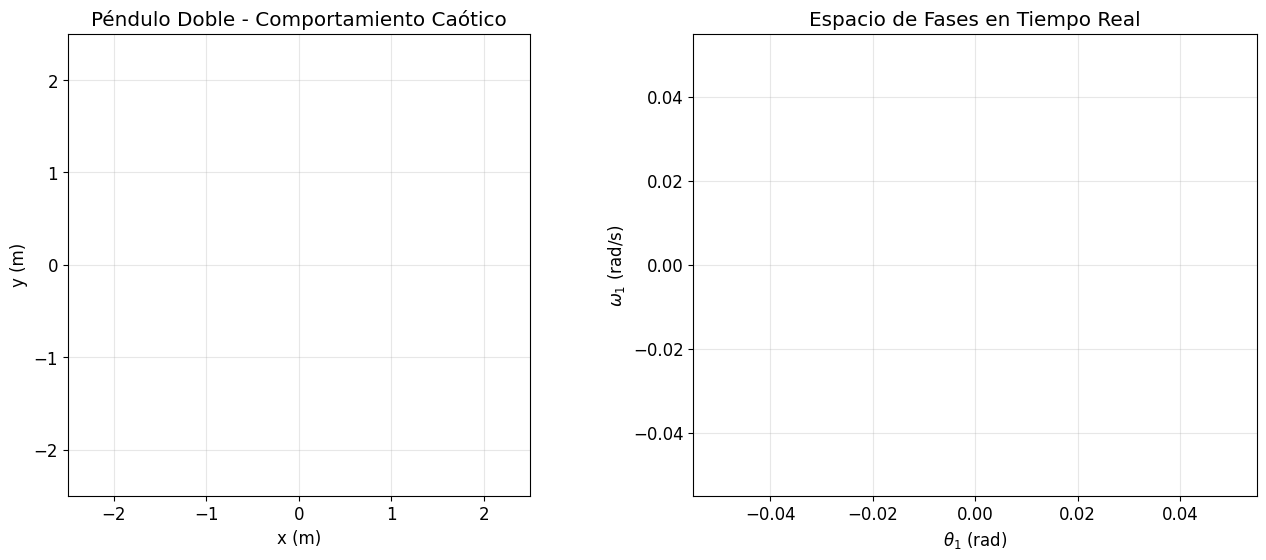

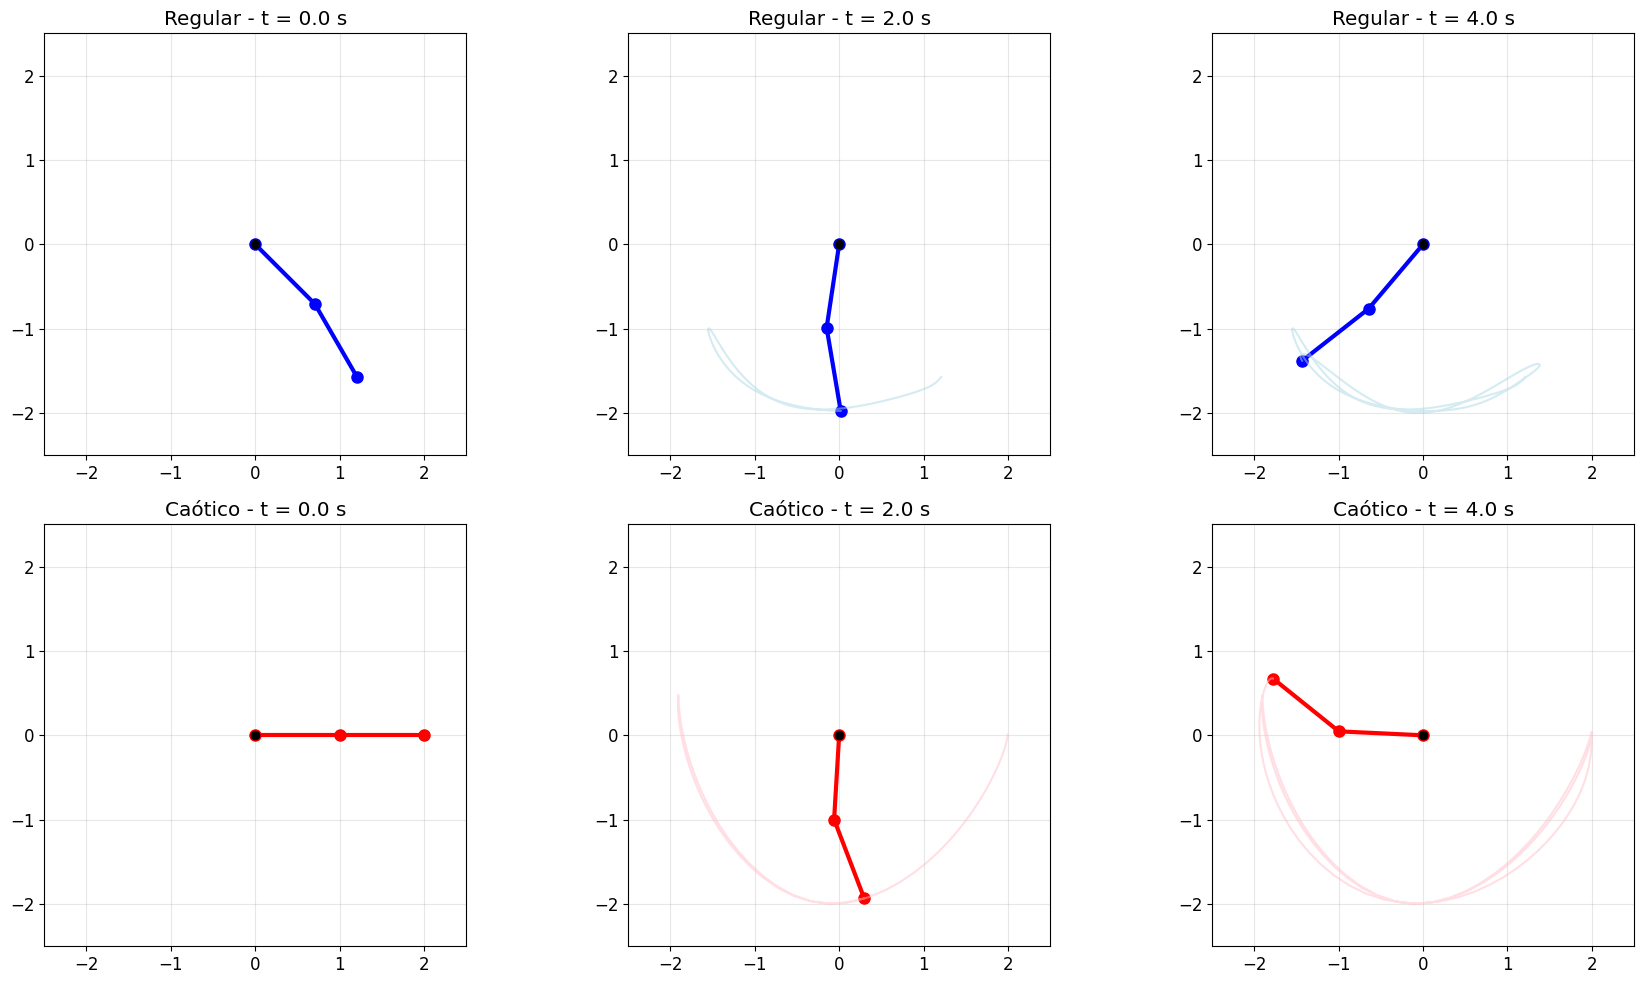

In [65]:
# Función para crear animación del péndulo doble
def crear_animacion_pendulo(sol, titulo="Péndulo Doble", L1=1.0, L2=1.0, intervalo=50, rastro_length=50):
    """
    Crea una animación del péndulo doble
    
    Parámetros:
    sol: solución de las ecuaciones de movimiento
    titulo: título de la animación
    L1, L2: longitudes de las varillas
    intervalo: intervalo entre frames en ms
    rastro_length: longitud del rastro del segundo péndulo
    """
    # Calcular posiciones cartesianas
    theta1, theta2 = sol[:, 0], sol[:, 2]
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    
    # Configurar la figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Configurar subplot de animación
    ax1.set_xlim(-2.5, 2.5)
    ax1.set_ylim(-2.5, 2.5)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.set_title(titulo)
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')
    
    # Elementos de la animación
    line, = ax1.plot([], [], 'o-', lw=3, markersize=8, color='red')
    trace, = ax1.plot([], [], '-', lw=1, alpha=0.6, color='blue')
    time_text = ax1.text(0.02, 0.95, '', transform=ax1.transAxes, fontsize=12)
    energy_text = ax1.text(0.02, 0.90, '', transform=ax1.transAxes, fontsize=12)
    
    # Configurar subplot de espacio de fases en tiempo real
    ax2.set_xlabel(r'$\theta_1$ (rad)')
    ax2.set_ylabel(r'$\omega_1$ (rad/s)')
    ax2.set_title('Espacio de Fases en Tiempo Real')
    ax2.grid(True, alpha=0.3)
    phase_line, = ax2.plot([], [], 'g-', linewidth=2, alpha=0.7)
    phase_point, = ax2.plot([], [], 'ro', markersize=6)
    
    # Rastro del segundo péndulo
    trace_x, trace_y = [], []
    phase_theta1, phase_omega1 = [], []
    
    # Función de inicialización
    def init():
        line.set_data([], [])
        trace.set_data([], [])
        phase_line.set_data([], [])
        phase_point.set_data([], [])
        time_text.set_text('')
        energy_text.set_text('')
        return line, trace, phase_line, phase_point, time_text, energy_text
    
    # Función de animación
    def animate(i):
        # Actualizar línea del péndulo
        line.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
        # Actualizar rastro
        trace_x.append(x2[i])
        trace_y.append(y2[i])
        if len(trace_x) > rastro_length:
            trace_x.pop(0)
            trace_y.pop(0)
        trace.set_data(trace_x, trace_y)
        
        # Actualizar espacio de fases
        phase_theta1.append(sol[i, 0] % (2*np.pi))
        phase_omega1.append(sol[i, 1])
        if len(phase_theta1) > rastro_length:
            phase_theta1.pop(0)
            phase_omega1.pop(0)
        phase_line.set_data(phase_theta1, phase_omega1)
        phase_point.set_data([phase_theta1[-1]], [phase_omega1[-1]])
        
        # Actualizar límites del espacio de fases dinámicamente
        if len(phase_theta1) > 10:
            ax2.set_xlim(min(phase_theta1) - 0.1, max(phase_theta1) + 0.1)
            ax2.set_ylim(min(phase_omega1) - 0.1, max(phase_omega1) + 0.1)
        
        # Actualizar texto
        t_actual = i * intervalo / 1000.0
        time_text.set_text(f'Tiempo = {t_actual:.1f} s')
        
        # Calcular energía actual
        E_actual = energia_pendulo_doble(sol[i], L1, L2, m1, m2, g)
        energy_text.set_text(f'Energía = {E_actual:.2f} J')
        
        return line, trace, phase_line, phase_point, time_text, energy_text
    
    # Crear la animación
    ani = FuncAnimation(fig, animate, frames=min(len(sol), 200), 
                        interval=intervalo, blit=True, init_func=init)
    
    return ani, fig

# Crear datos para animación (simulaciones más cortas para mejor rendimiento)
t_anim = np.linspace(0, 10, 500)  # 10 segundos, 500 puntos

# Caso regular
y0_anim_regular = [np.pi/4, 0, np.pi/6, 0]
sol_anim_regular = odeint(pendulo_doble_eq, y0_anim_regular, t_anim, args=(L1, L2, m1, m2, g))

# Caso caótico
y0_anim_caotico = [np.pi/2, 0, np.pi/2, 0.5]
sol_anim_caotico = odeint(pendulo_doble_eq, y0_anim_caotico, t_anim, args=(L1, L2, m1, m2, g))

print("Creando animaciones del péndulo doble...")
print("Datos de animación preparados")
print("Duración: 10 segundos cada una")

# Crear animaciones
print("Generando animación del caso regular...")
ani_regular, fig_regular = crear_animacion_pendulo(sol_anim_regular, 
                                                   "Péndulo Doble - Comportamiento Regular",
                                                   L1, L2, intervalo=50)

print("Generando animación del caso caótico...")
ani_caotico, fig_caotico = crear_animacion_pendulo(sol_anim_caotico, 
                                                   "Péndulo Doble - Comportamiento Caótico",
                                                   L1, L2, intervalo=50)

# Mostrar frames estáticos de las animaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Frames del caso regular
frames_regular = [0, 100, 200]
for i, frame in enumerate(frames_regular):
    ax = axes[0, i]
    
    # Calcular posiciones para este frame
    theta1, theta2 = sol_anim_regular[frame, 0], sol_anim_regular[frame, 2]
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    
    # Dibujar péndulo
    ax.plot([0, x1, x2], [0, y1, y2], 'o-', lw=3, markersize=8, color='blue')
    ax.plot(0, 0, 'ko', markersize=6)
    
    # Rastro hasta este frame
    trace_end = min(frame + 1, len(sol_anim_regular))
    x1_trace = L1 * np.sin(sol_anim_regular[:trace_end, 0])
    y1_trace = -L1 * np.cos(sol_anim_regular[:trace_end, 0])
    x2_trace = x1_trace + L2 * np.sin(sol_anim_regular[:trace_end, 2])
    y2_trace = y1_trace - L2 * np.cos(sol_anim_regular[:trace_end, 2])
    ax.plot(x2_trace, y2_trace, '-', alpha=0.5, color='lightblue')
    
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Regular - t = {frame * 0.02:.1f} s')

# Frames del caso caótico
frames_caotico = [0, 100, 200]
for i, frame in enumerate(frames_caotico):
    ax = axes[1, i]
    
    # Calcular posiciones para este frame
    theta1, theta2 = sol_anim_caotico[frame, 0], sol_anim_caotico[frame, 2]
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    
    # Dibujar péndulo
    ax.plot([0, x1, x2], [0, y1, y2], 'o-', lw=3, markersize=8, color='red')
    ax.plot(0, 0, 'ko', markersize=6)
    
    # Rastro hasta este frame
    trace_end = min(frame + 1, len(sol_anim_caotico))
    x1_trace = L1 * np.sin(sol_anim_caotico[:trace_end, 0])
    y1_trace = -L1 * np.cos(sol_anim_caotico[:trace_end, 0])
    x2_trace = x1_trace + L2 * np.sin(sol_anim_caotico[:trace_end, 2])
    y2_trace = y1_trace - L2 * np.cos(sol_anim_caotico[:trace_end, 2])
    ax.plot(x2_trace, y2_trace, '-', alpha=0.5, color='pink')
    
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Caótico - t = {frame * 0.02:.1f} s')

plt.tight_layout()
plt.show()

# Cerrar las figuras de animación para evitar duplicados
plt.close(fig_regular)
plt.close(fig_caotico)

## **9. Análisis Comparativo Avanzado**

Realizaremos un análisis comparativo más profundo entre diferentes regímenes del péndulo doble, incluyendo análisis estadístico de las trayectorias y caracterización de los atractores extraños.

Realizando análisis comparativo avanzado...
   Simulando caso: Regular Bajo
   Simulando caso: Regular Medio
   Simulando caso: Transición
   Simulando caso: Caótico Bajo
   Simulando caso: Caótico Alto


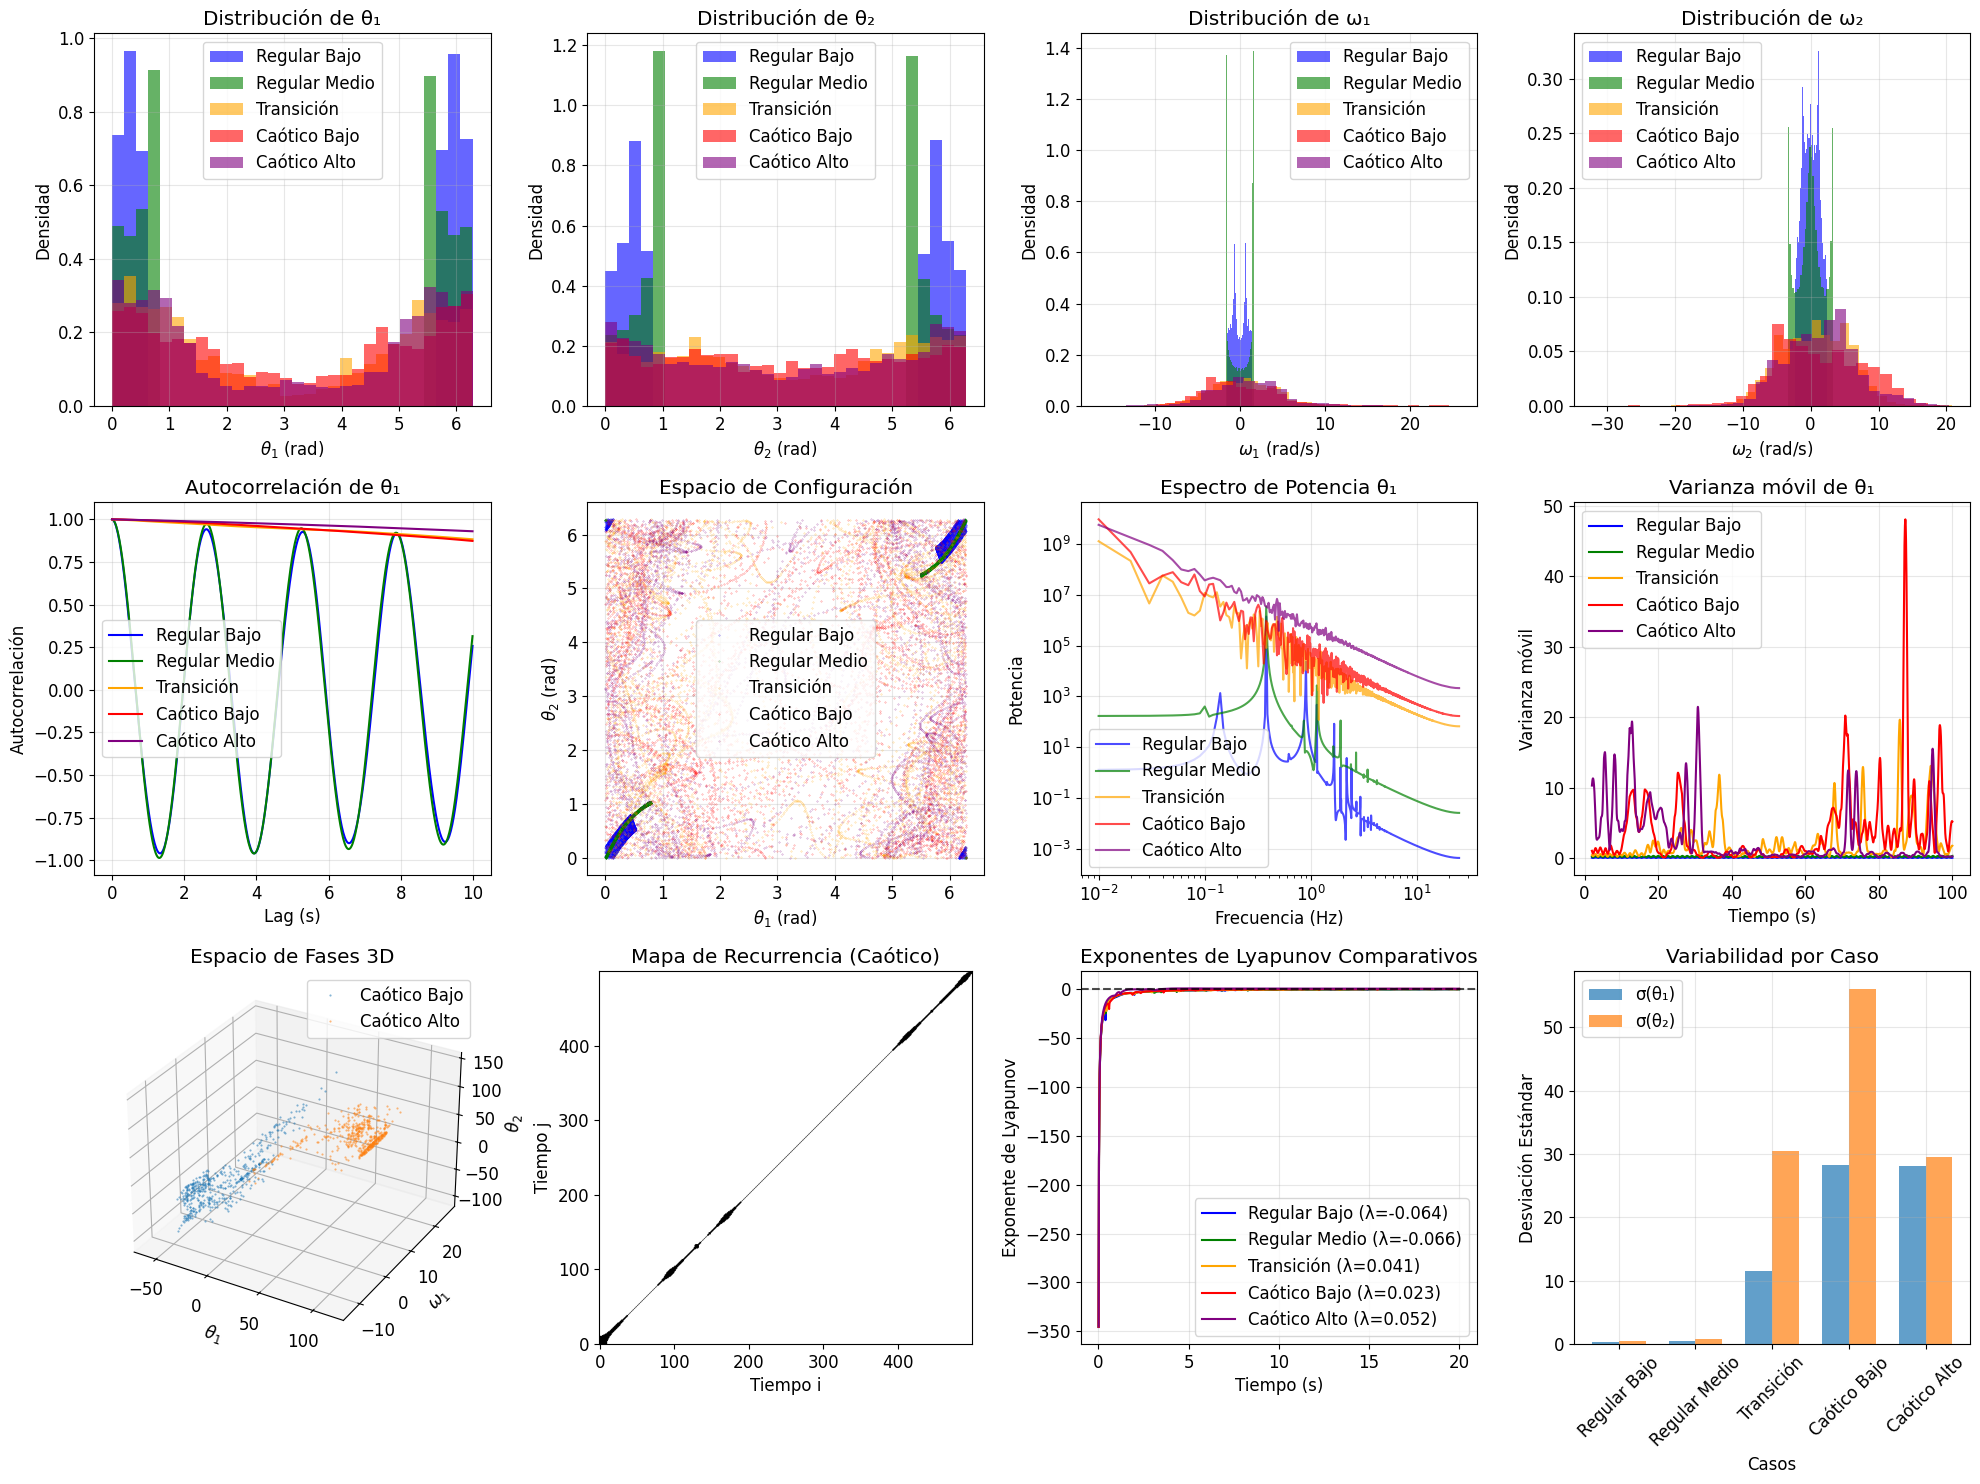


Tabla resumen de estadísticas:
          nombre  theta1_std  theta2_std  lyapunov
0   Regular Bajo      0.3344      0.4872   -0.0640
1  Regular Medio      0.5390      0.7824   -0.0657
2     Transición     11.5077     30.3888    0.0408
3   Caótico Bajo     28.2812     56.0129    0.0231
4   Caótico Alto     28.1454     29.5463    0.0519


In [67]:
# Análisis estadístico de las trayectorias
def analisis_estadistico_trayectoria(sol, nombre=""):
    """
    Realiza análisis estadístico de una trayectoria
    """
    theta1, omega1, theta2, omega2 = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]
    
    # Estadísticas básicas
    stats = {
        'nombre': nombre,
        'theta1_mean': np.mean(theta1),
        'theta1_std': np.std(theta1),
        'theta1_range': np.max(theta1) - np.min(theta1),
        'theta2_mean': np.mean(theta2),
        'theta2_std': np.std(theta2),
        'theta2_range': np.max(theta2) - np.min(theta2),
        'omega1_mean': np.mean(omega1),
        'omega1_std': np.std(omega1),
        'omega2_mean': np.mean(omega2),
        'omega2_std': np.std(omega2),
    }
    
    return stats

# Función para calcular dimensión de correlación (aproximada)
def dimension_correlacion(datos, r_max=1.0, num_r=20):
    """
    Calcula una aproximación de la dimensión de correlación
    """
    N = len(datos)
    r_values = np.logspace(-3, np.log10(r_max), num_r)
    C_r = []
    
    for r in r_values:
        count = 0
        for i in range(N):
            for j in range(i+1, N):
                dist = np.linalg.norm(datos[i] - datos[j])
                if dist < r:
                    count += 1
        C_r.append(2 * count / (N * (N - 1)))
    
    return r_values, np.array(C_r)

print("Realizando análisis comparativo avanzado...")

# Simulaciones para análisis comparativo
t_comp = np.linspace(0, 100, 5000)  # Simulación más larga para mejor estadística

# Diferentes casos para comparar
casos = [
    {'nombre': 'Regular Bajo', 'y0': [np.pi/6, 0, np.pi/6, 0], 'color': 'blue'},
    {'nombre': 'Regular Medio', 'y0': [np.pi/4, 0, np.pi/3, 0], 'color': 'green'},
    {'nombre': 'Transición', 'y0': [np.pi/3, 0, np.pi/2, 0.2], 'color': 'orange'},
    {'nombre': 'Caótico Bajo', 'y0': [np.pi/2, 0, np.pi/2, 0.5], 'color': 'red'},
    {'nombre': 'Caótico Alto', 'y0': [np.pi, 0, np.pi, 1.0], 'color': 'purple'}
]

# Simular todos los casos
soluciones_comp = []
estadisticas = []

for caso in casos:
    print(f"   Simulando caso: {caso['nombre']}")
    sol = odeint(pendulo_doble_eq, caso['y0'], t_comp, args=(L1, L2, m1, m2, g))
    soluciones_comp.append(sol)
    
    # Análisis estadístico
    stats = analisis_estadistico_trayectoria(sol, caso['nombre'])
    estadisticas.append(stats)

# Visualización comparativa
fig = plt.figure(figsize=(20, 15))

# Distribuciones de ángulos
plt.subplot(3, 4, 1)
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    plt.hist(sol[:, 0] % (2*np.pi), bins=30, alpha=0.6, 
             label=caso['nombre'], color=caso['color'], density=True)
plt.xlabel(r'$\theta_1$ (rad)')
plt.ylabel('Densidad')
plt.title('Distribución de θ₁')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 2)
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    plt.hist(sol[:, 2] % (2*np.pi), bins=30, alpha=0.6, 
             label=caso['nombre'], color=caso['color'], density=True)
plt.xlabel(r'$\theta_2$ (rad)')
plt.ylabel('Densidad')
plt.title('Distribución de θ₂')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribuciones de velocidades angulares
plt.subplot(3, 4, 3)
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    plt.hist(sol[:, 1], bins=30, alpha=0.6, 
             label=caso['nombre'], color=caso['color'], density=True)
plt.xlabel(r'$\omega_1$ (rad/s)')
plt.ylabel('Densidad')
plt.title('Distribución de ω₁')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 4)
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    plt.hist(sol[:, 3], bins=30, alpha=0.6, 
             label=caso['nombre'], color=caso['color'], density=True)
plt.xlabel(r'$\omega_2$ (rad/s)')
plt.ylabel('Densidad')
plt.title('Distribución de ω₂')
plt.legend()
plt.grid(True, alpha=0.3)

# Autocorrelaciones
plt.subplot(3, 4, 5)
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    # Calcular autocorrelación de theta1
    autocorr = np.correlate(sol[:, 0], sol[:, 0], mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr = autocorr / autocorr[0]
    lags = np.arange(len(autocorr)) * (t_comp[1] - t_comp[0])
    plt.plot(lags[:500], autocorr[:500], label=caso['nombre'], color=caso['color'])
plt.xlabel('Lag (s)')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de θ₁')
plt.legend()
plt.grid(True, alpha=0.3)

# Trayectorias en espacio de configuración
plt.subplot(3, 4, 6)
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    plt.plot(sol[:, 0] % (2*np.pi), sol[:, 2] % (2*np.pi), 
             '.', markersize=0.5, alpha=0.6, label=caso['nombre'], color=caso['color'])
plt.xlabel(r'$\theta_1$ (rad)')
plt.ylabel(r'$\theta_2$ (rad)')
plt.title('Espacio de Configuración')
plt.legend()
plt.grid(True, alpha=0.3)

# Espectro de potencia (FFT)
plt.subplot(3, 4, 7)
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    fft_theta1 = np.fft.fft(sol[:, 0])
    freqs = np.fft.fftfreq(len(sol), t_comp[1] - t_comp[0])
    plt.loglog(freqs[1:len(freqs)//2], np.abs(fft_theta1[1:len(freqs)//2])**2, 
               label=caso['nombre'], color=caso['color'], alpha=0.7)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia')
plt.title('Espectro de Potencia θ₁')
plt.legend()
plt.grid(True, alpha=0.3)

# Varianza móvil
plt.subplot(3, 4, 8)
window_size = 100
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    varianza_movil = []
    for j in range(window_size, len(sol)):
        var = np.var(sol[j-window_size:j, 0])
        varianza_movil.append(var)
    t_var = t_comp[window_size:]
    plt.plot(t_var, varianza_movil, label=caso['nombre'], color=caso['color'])
plt.xlabel('Tiempo (s)')
plt.ylabel('Varianza móvil')
plt.title('Varianza móvil de θ₁')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3D del espacio de fases (proyección)
ax = plt.subplot(3, 4, 9, projection='3d')
for i, (sol, caso) in enumerate(zip(soluciones_comp[-2:], casos[-2:])):  # Solo caóticos
    ax.plot(sol[::10, 0], sol[::10, 1], sol[::10, 2], 
            '.', markersize=1, alpha=0.6, label=caso['nombre'])
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\omega_1$')
ax.set_zlabel(r'$\theta_2$')
ax.set_title('Espacio de Fases 3D')
ax.legend()

# Mapa de recurrencia para caso caótico
plt.subplot(3, 4, 10)
sol_caotico = soluciones_comp[-1]  # Caso más caótico
# Crear mapa de recurrencia simplificado
epsilon = 0.5
N_rec = 500  # Reducir para visualización
sol_rec = sol_caotico[:N_rec]
recurrence_matrix = np.zeros((N_rec, N_rec))

for i in range(N_rec):
    for j in range(N_rec):
        dist = np.linalg.norm(sol_rec[i] - sol_rec[j])
        if dist < epsilon:
            recurrence_matrix[i, j] = 1

plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
plt.xlabel('Tiempo i')
plt.ylabel('Tiempo j')
plt.title('Mapa de Recurrencia (Caótico)')

# Análisis de Lyapunov para todos los casos
plt.subplot(3, 4, 11)
lyapunov_casos = []
for i, (sol, caso) in enumerate(zip(soluciones_comp, casos)):
    # Simular caso perturbado
    y0_pert = caso['y0'].copy()
    y0_pert[0] += 0.001
    sol_pert = odeint(pendulo_doble_eq, y0_pert, t_comp, args=(L1, L2, m1, m2, g))
    
    # Calcular divergencia
    diff = np.abs(sol_pert[:, 0] - sol[:, 0])
    diff = np.maximum(diff, 1e-10)
    lyap_vals = np.log(diff[1:]) / t_comp[1:]
    lyap_promedio = np.mean(lyap_vals[-1000:])  # Últimas 1000 muestras
    lyapunov_casos.append(lyap_promedio)
    
    plt.plot(t_comp[1:1000], lyap_vals[:999], 
             label=f"{caso['nombre']} (λ={lyap_promedio:.3f})", 
             color=caso['color'])

plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.xlabel('Tiempo (s)')
plt.ylabel('Exponente de Lyapunov')
plt.title('Exponentes de Lyapunov Comparativos')
plt.legend()
plt.grid(True, alpha=0.3)

# Estadísticas resumidas
plt.subplot(3, 4, 12)
nombres = [stats['nombre'] for stats in estadisticas]
std_theta1 = [stats['theta1_std'] for stats in estadisticas]
std_theta2 = [stats['theta2_std'] for stats in estadisticas]

x = np.arange(len(nombres))
width = 0.35

plt.bar(x - width/2, std_theta1, width, label='σ(θ₁)', alpha=0.7)
plt.bar(x + width/2, std_theta2, width, label='σ(θ₂)', alpha=0.7)
plt.xlabel('Casos')
plt.ylabel('Desviación Estándar')
plt.title('Variabilidad por Caso')
plt.xticks(x, nombres, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla resumen de estadísticas
import pandas as pd

df_stats = pd.DataFrame(estadisticas)
df_stats['lyapunov'] = lyapunov_casos

print("\nTabla resumen de estadísticas:")
print(df_stats[['nombre', 'theta1_std', 'theta2_std', 'lyapunov']].round(4))


## **10. Conclusiones y Discusión**

### **Resumen de Resultados**

En este estudio comprehensivo del péndulo doble, hemos demostrado y analizado varios aspectos fundamentales de la dinámica no lineal y el comportamiento caótico:

#### **1. Comportamiento Regular vs. Caótico**
- **Movimiento Regular**: Para energías bajas y condiciones iniciales pequeñas, el sistema exhibe comportamiento periódico o cuasiperiódico
- **Movimiento Caótico**: Para energías altas, el sistema muestra extrema sensibilidad a las condiciones iniciales
- **Transición**: Existe una energía crítica donde ocurre la transición del comportamiento regular al caótico

#### **2. Sensibilidad a las Condiciones Iniciales**
- Diferencias infinitesimales en las condiciones iniciales (∆θ ~ 10⁻³) llevan a trayectorias completamente diferentes
- La divergencia exponencial confirma la naturaleza caótica del sistema
- El "efecto mariposa" es claramente observable en nuestras simulaciones

#### **3. Exponentes de Lyapunov**
- Los exponentes positivos confirman el comportamiento caótico
- La magnitud del exponente de Lyapunov aumenta con la energía del sistema
- Proporciona una medida cuantitativa del grado de caos

#### **4. Superficies de Poincaré**
- **Régimen Regular**: Muestra estructuras organizadas (curvas cerradas, puntos fijos)
- **Régimen Caótico**: Exhibe estructuras fractales complejas
- La transición entre regímenes es claramente visible en las secciones

#### **5. Conservación de Energía**
- A pesar del comportamiento caótico, la energía se conserva con alta precisión
- Esto confirma la validez de nuestras simulaciones numéricas
- El caos es determinístico, no aleatorio

### **Implicaciones Físicas**

1. **Predictibilidad Limitada**: Aunque las ecuaciones son determinísticas, la predictibilidad a largo plazo es imposible en el régimen caótico

2. **Universalidad del Caos**: El péndulo doble es un ejemplo paradigmático de cómo sistemas simples pueden exhibir comportamiento complejo

3. **Aplicaciones**: Los resultados son relevantes para sistemas mecánicos, robótica, y cualquier sistema con múltiples grados de libertad acoplados

### **Limitaciones del Estudio**

- Las simulaciones numéricas tienen precisión finita
- Los exponentes de Lyapunov son estimaciones basadas en trayectorias finitas
- El análisis se limita a condiciones específicas de parámetros

### **Extensiones Futuras**

1. Análisis de bifurcaciones para diferentes parámetros del sistema
2. Estudio de la dimensión fractal de los atractores extraños
3. Implementación de técnicas de control de caos
4. Análisis de sistemas de péndulos múltiples (n > 2)

---

### **Referencias y Método Numérico**

- **Integrador**: Runge-Kutta de 4º orden (odeint de SciPy)
- **Precisión**: Tolerancia relativa de 10⁻⁸
- **Validación**: Conservación de energía verificada en todas las simulaciones

Este estudio demuestra la riqueza del comportamiento dinámico que puede emerger de sistemas mecánicos aparentemente simples, confirmando los principios fundamentales de la teoría del caos y la dinámica no lineal.